### 필수 라이브러리
- !pip install jupyter-dash

In [1]:
import pandas as pd
rawdf = pd.read_excel("")
### 파일 이름 삽입 후 불러오기
rawdf

In [2]:
def 브랜드재구메데이터(brand):
    global rawdf
    df = rawdf[rawdf.상품 == brand]
    ### 에러시 추가    
    df['결제일'] = df['결제일'].apply(lambda x: str(x)[:10])

    df1 = df.copy()
    df1 = df1[['전화번호', '결제일']]
    df1 = df1.drop_duplicates(subset=['전화번호'], keep='first')
    df1.rename(columns = {'결제일':'첫구매날짜'}, inplace = True)

    df2 = df.copy()
    df2 = df2.sort_values(by=['전화번호', '결제일'], ascending=[True, False])
    df2 = df2[['전화번호', '결제일']]
    df2 = df2.drop_duplicates(subset=['전화번호'], keep='first')
    df2.rename(columns = {'결제일':'마지막구매날짜'}, inplace = True)

    df = pd.merge(df, df1, how = 'left', on = '전화번호')
    df = pd.merge(df, df2, how = 'left', on = '전화번호')

    df = df.set_index('결제일')
    df = df.reset_index()

    #총 결제수
    df_buycount = df.pivot_table(index=['전화번호'], aggfunc='size')
    df_buycount = df_buycount.reset_index()
    df_buycount.rename(columns = {0:'총 결제수'}, inplace = True)

    df_test = pd.merge(df, df_buycount, how = 'left', on = '전화번호')

    #구매 빈도수 
    df_Purchasefrequency = df.drop_duplicates(['전화번호', '결제일']).pivot_table(index=['전화번호'], aggfunc='size')
    df_Purchasefrequency = df_Purchasefrequency.reset_index()
    df_Purchasefrequency.rename(columns = {0:'결제빈도'}, inplace = True)

    df_test = pd.merge(df_test, df_Purchasefrequency, how = 'left', on = '전화번호')

    df_test['재구매회원'] = '첫구매회원'
    df_test['재구매회원'].loc[df_test['결제빈도'] > 1] = '재구매회원'

    df_test = df_test[['결제빈도', '총 결제수', '결제일', '결제주', '채널', '주문번호', '이름', '전화번호', '상품명', '옵션명', '상품', '상품ID', '배송날짜', '배송주소', '결제액', '배송비', '수량', '재구매회원', '첫구매날짜', '마지막구매날짜']]

    df_test = df_test.sort_values(by=['결제빈도', '총 결제수', '전화번호', '결제일', '결제액'], ascending=[False, False, True, False, False])

    df_test = df_test.set_index('결제빈도')
    df_test = df_test.reset_index()

    df_test['첫구매유무'] = '재구매'

    df_test['첫구매유무'].loc[(df_test['재구매회원'] == '첫구매회원') | (df_test['결제일'] == df_test['첫구매날짜'])] = '첫구매'

    df_test['마지막구매유무'] = 'no'
    df_test['결제액'] = df_test['결제액'].apply(lambda x: int(x))
    df_test['마지막구매유무'].loc[(df_test['결제일'] == df_test['마지막구매날짜'])] = 'yes'
    return df_test

In [3]:
from datetime import date, datetime, timedelta
import plotly.express as px
from jupyter_dash import JupyterDash
import dash_core_components as dcc
import dash_html_components as html
from dash.dependencies import Input, Output
import numpy as np
import time
external_stylesheets = ['https://codepen.io/chriddyp/pen/bWLwgP.css']
app = JupyterDash(__name__,external_stylesheets=external_stylesheets)
colors = {
    'background': '#111111',
    'text': '#7FDBFF'
}

app.layout = html.Div([
    html.H4('브랜드별 주차별 매출', style={'textAlign': 'center', 'color': '#7FDBFF'}),
    html.H6('브랜드 필터'),
    dcc.Dropdown(
        id="dropdown",
        options=[], #### str 형식으로 옵션명 삽입, 이 코드 같은 경우는 브랜드리스트를 삽입
        placeholder="Select a brand",
        clearable=False,
    ),
    html.H6('날짜 필터'),
    dcc.DatePickerRange(
        id='my-date-picker-range',
        min_date_allowed=date(2019, 4, 22),
        max_date_allowed=date(2022, 7, 24),
        initial_visible_month=date(2022, 7, 24),
    ),
    dcc.Graph(id="graph"),
    html.H4('브랜드별 주차별 채널별 매출', style={'textAlign': 'center', 'color': '#7FDBFF'}),
    html.H6('브랜드 필터'),
    dcc.Dropdown(
        id="dropdown2",
        options=, ### 위의 options와 같은 리스트라고 생각하면 됨
        placeholder="Select a brand",
        clearable=False,
    ),
    html.H6('날짜 필터'),
    dcc.DatePickerRange(
        id='my-date-picker-range2',
        min_date_allowed=date(2019, 4, 22),
        max_date_allowed=date(2022, 7, 24),
        initial_visible_month=date(2022, 7, 24),
    ),
    dcc.Graph(id="graph2"),

])


@app.callback(
    Output("graph", "figure"), 
    [Input("dropdown", "value"),
    Input('my-date-picker-range', 'start_date'),
    Input('my-date-picker-range', 'end_date')])



def update_graph(brand,start_date,end_date):
    string_prefix = 'You have selected: '
    if start_date is not None:
        start_date_object = date.fromisoformat(start_date)
        start_date_string = start_date_object.strftime('%Y-%m-%d')
        string_prefix = string_prefix + 'Start Date: ' + start_date_string + ' | '
    if end_date is not None:
        end_date_object = date.fromisoformat(end_date)
        end_date_string = end_date_object.strftime('%Y-%m-%d')
        string_prefix = string_prefix + 'End Date: ' + end_date_string

    df_test = 브랜드재구메데이터(brand)
    qq = df_test.loc[(df_test['결제일']>=start_date_string)&(df_test['결제일']<=end_date_string)]
    fig = px.histogram(qq.sort_values(by='결제주'), x="결제주", y="결제액", color='첫구매유무', barmode="group")
    
    
    

    return fig

@app.callback(
    Output("graph2", "figure"), 
    [Input("dropdown2", "value"),
    Input('my-date-picker-range2', 'start_date'),
    Input('my-date-picker-range2', 'end_date')])



def update_graph(brand,start_date,end_date):
    string_prefix = 'You have selected: '
    if start_date is not None:
        start_date_object = date.fromisoformat(start_date)
        start_date_string = start_date_object.strftime('%Y-%m-%d')
        string_prefix = string_prefix + 'Start Date: ' + start_date_string + ' | '
    if end_date is not None:
        end_date_object = date.fromisoformat(end_date)
        end_date_string = end_date_object.strftime('%Y-%m-%d')
        string_prefix = string_prefix + 'End Date: ' + end_date_string

    df_test = 브랜드재구메데이터(brand)
    qq = df_test.loc[(df_test['결제일']>=start_date_string)&(df_test['결제일']<=end_date_string)]
    fig = px.histogram(qq.sort_values(by='결제주'), x="채널", y="결제액", color='첫구매유무', barmode="group")
    
    
    

    return fig



app.run_server(debug=True)

<ipython-input-3-0f02b92cbadc>:4: UserWarning: 
The dash_core_components package is deprecated. Please replace
`import dash_core_components as dcc` with `from dash import dcc`
  import dash_core_components as dcc
<ipython-input-3-0f02b92cbadc>:5: UserWarning: 
The dash_html_components package is deprecated. Please replace
`import dash_html_components as html` with `from dash import html`
  import dash_html_components as html


Dash app running on http://127.0.0.1:8050/


C:\Users\OWNER\anaconda3\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\OWNER\anaconda3\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



### 실행시 결과 화면 예시

- 첫번째 그래프
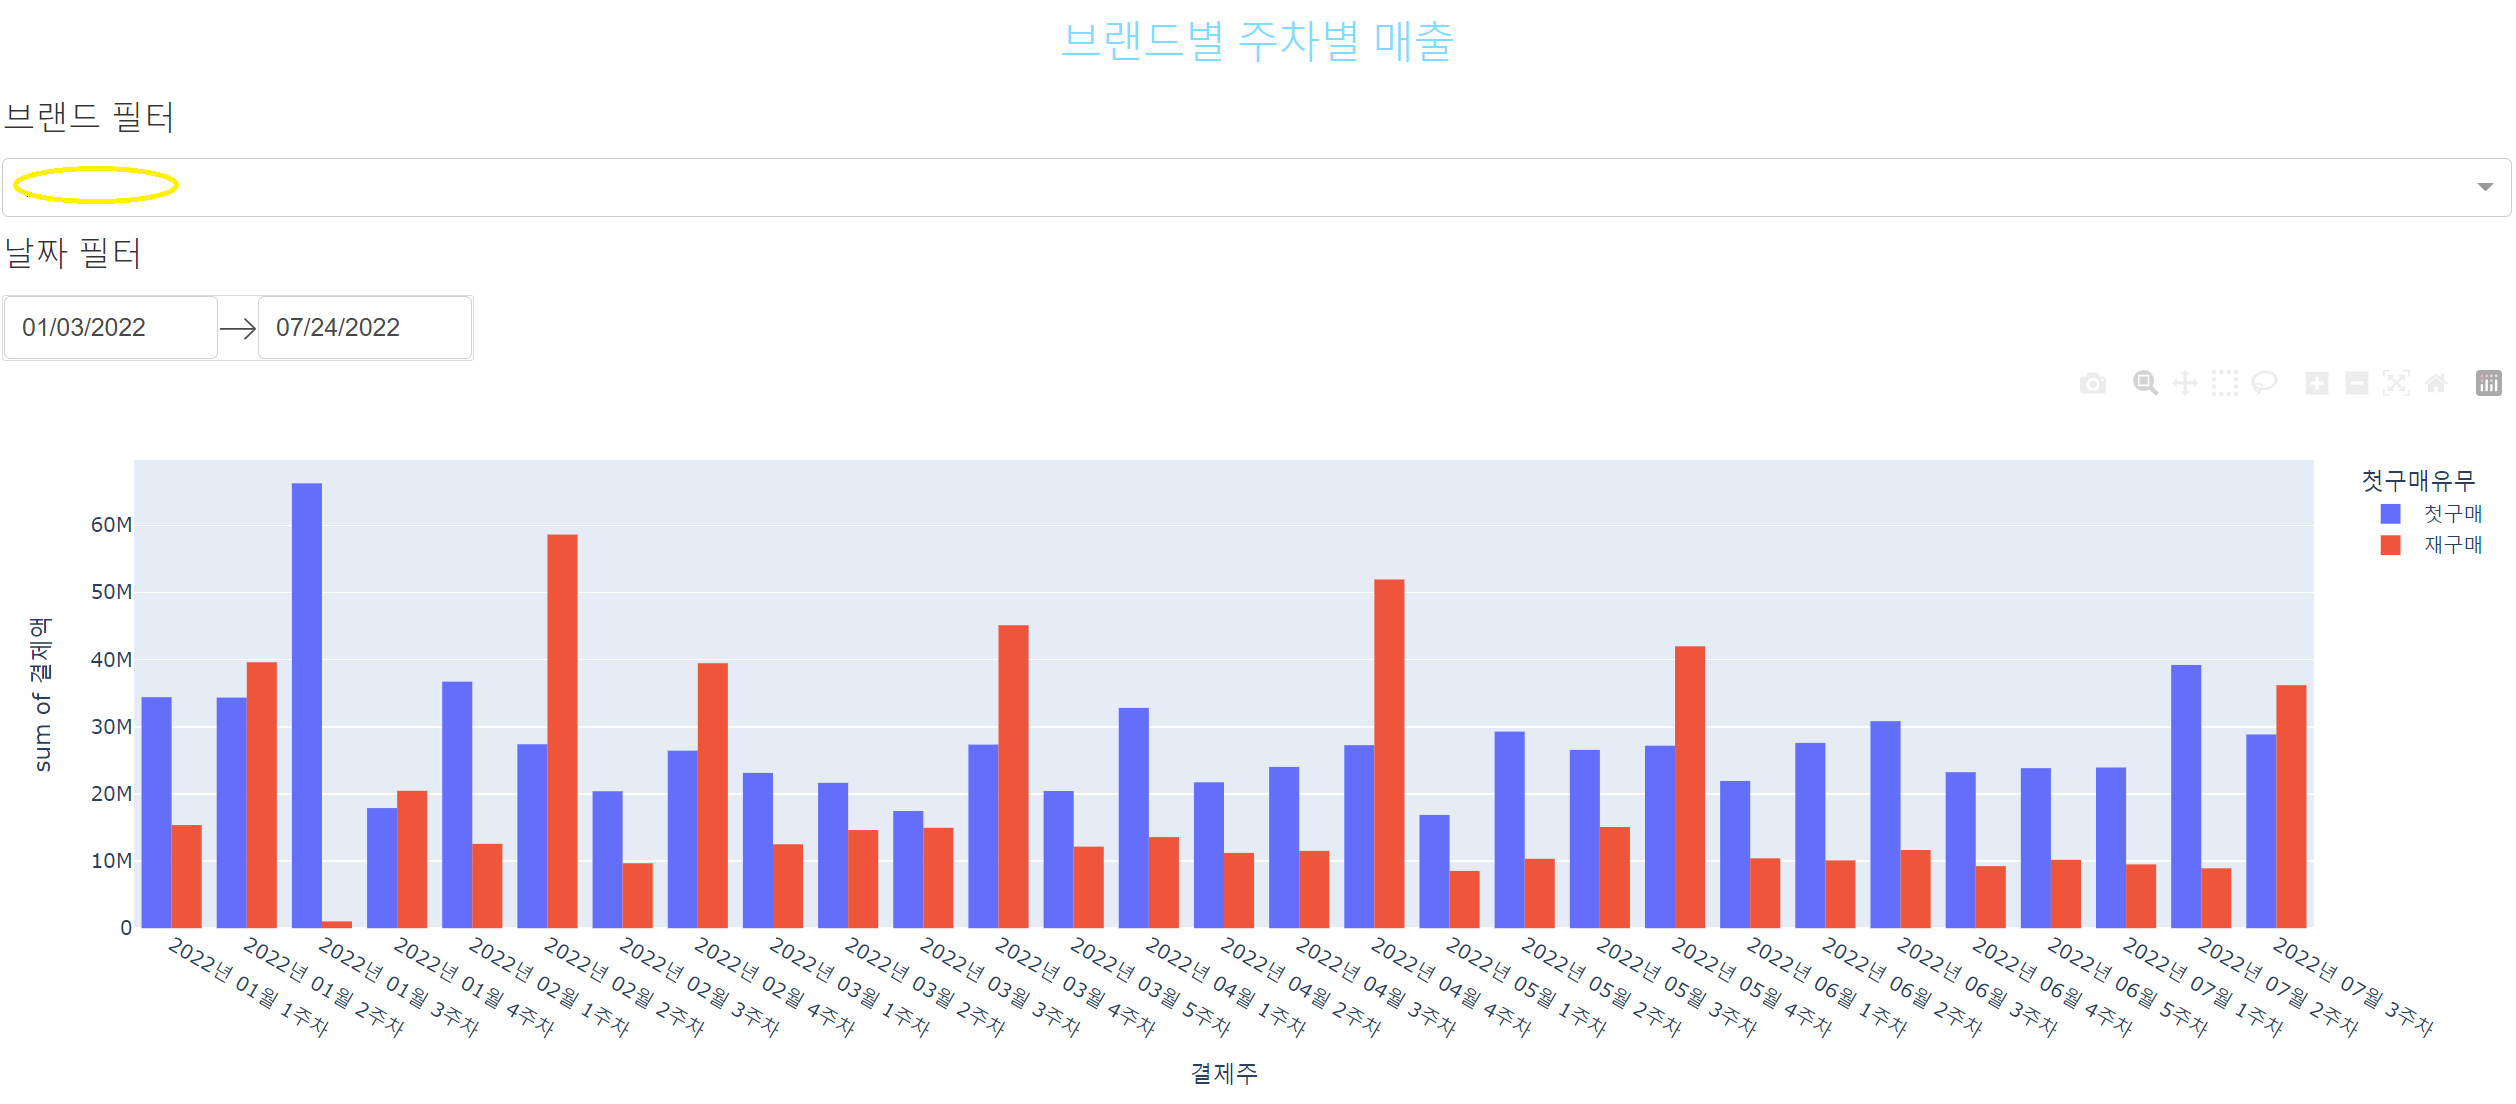
    - 원하는 브랜드와 원하는 날짜를 선택하면 주차별로 해당 주차의 첫구매와 재구매 비중을 그래프로 나타내준다.

- 두번째 그래프
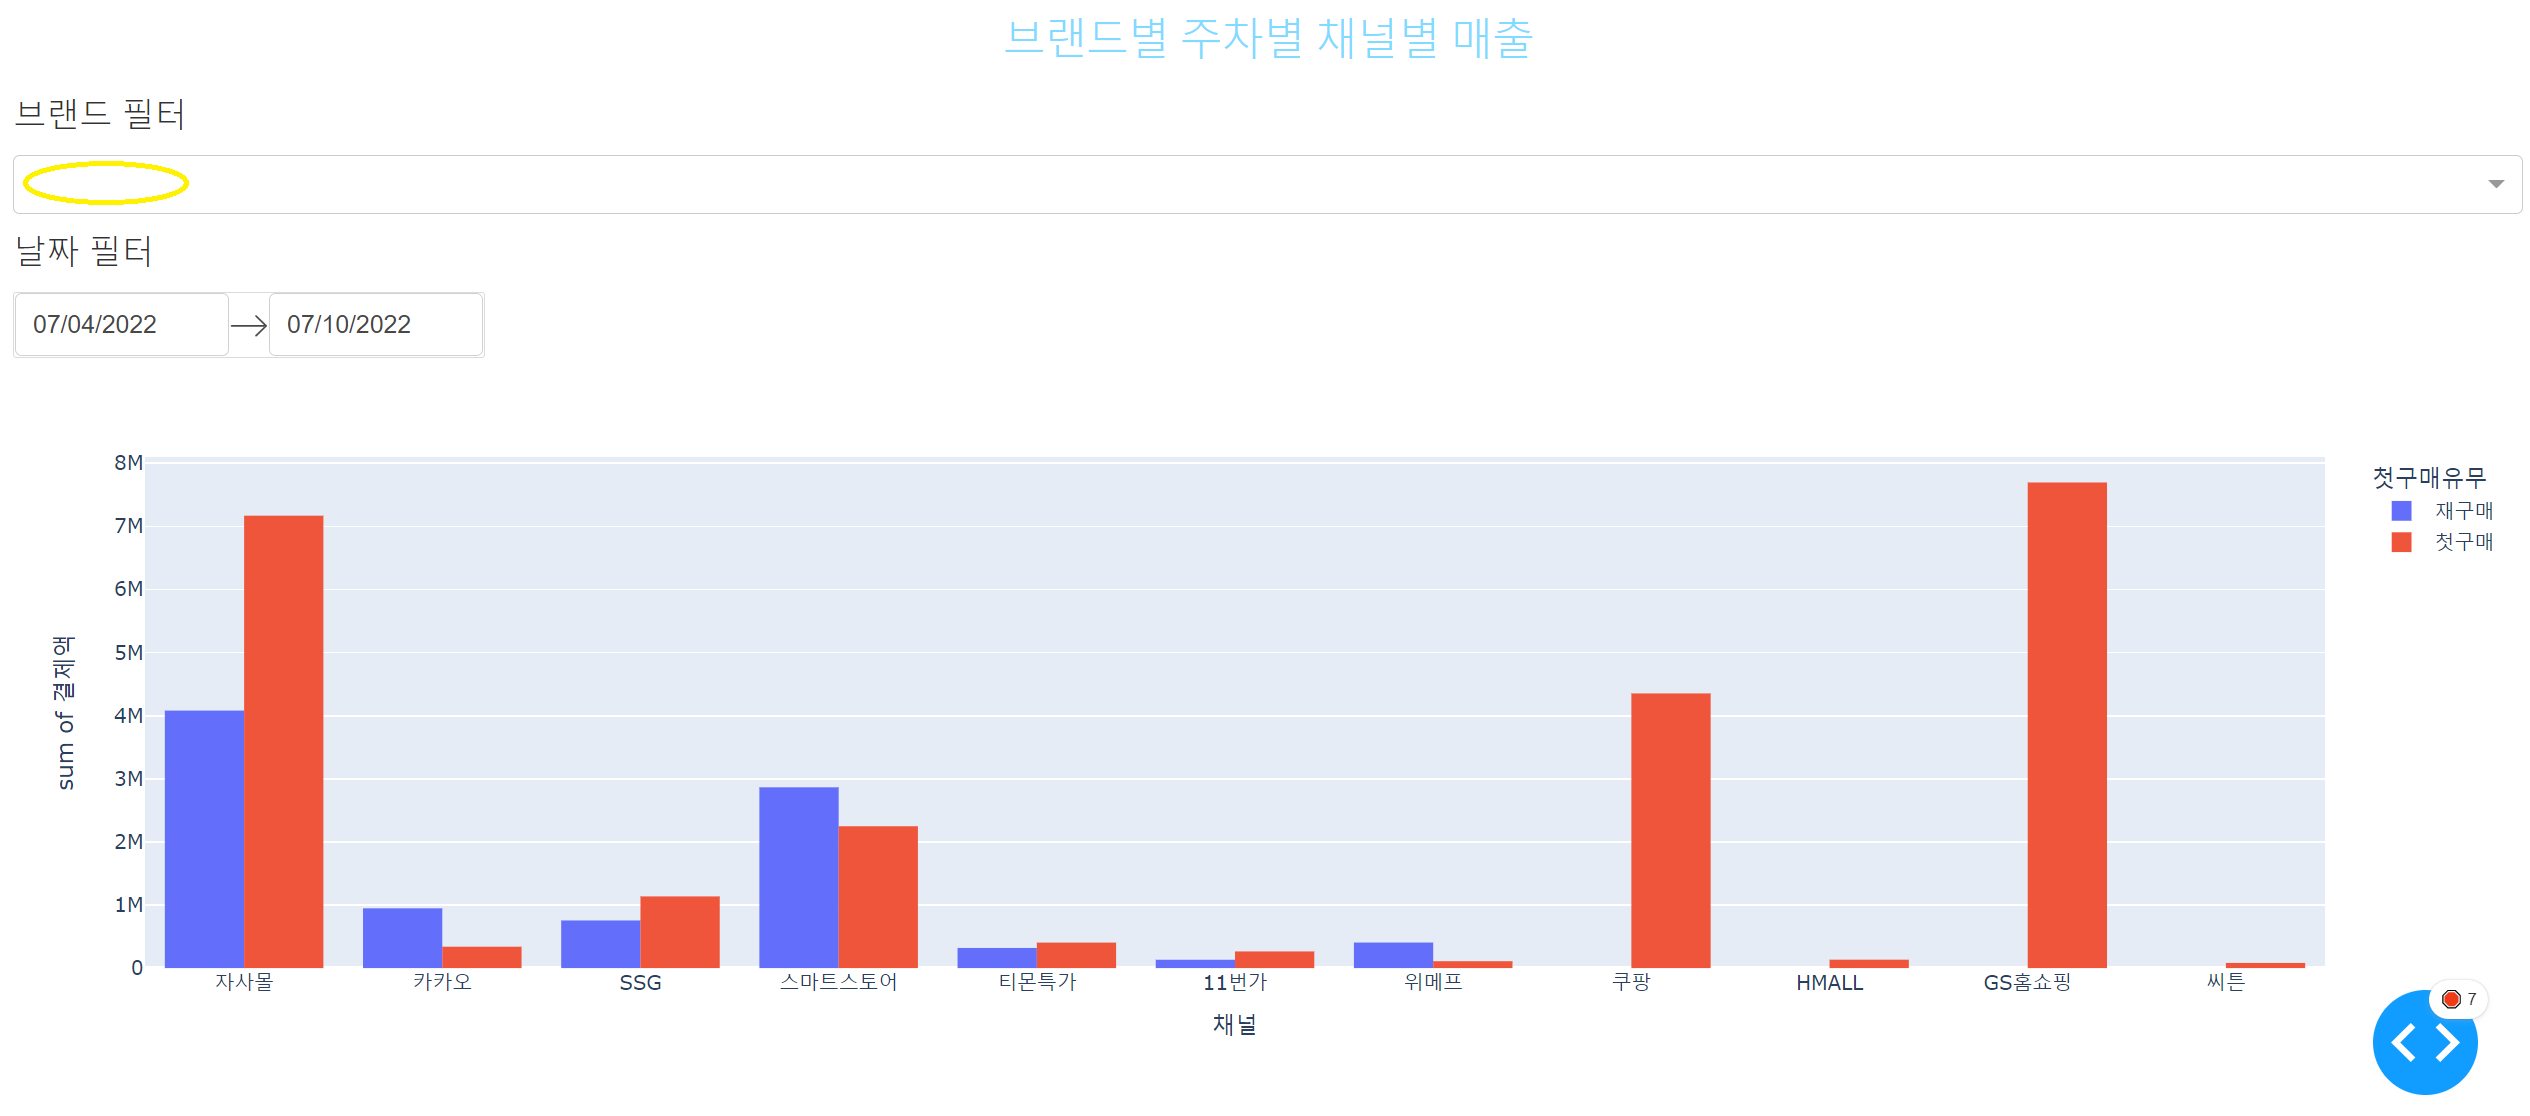
    - 원하는 브랜드와 원하는 주차의 시작일과 끝나는 날을 선택하면 그 주차의 채널별 매출 데이터를 첫구매와 재구매로 나누어 그래프로 나타내준다